scope_63  SNR: 30.41
scope_64  SNR: 32.77
scope_65  SNR: 35.89
scope_66  SNR: 28.39
scope_67  SNR: 30.90
scope_68  SNR: 28.71
scope_69  SNR: 28.81
scope_70  SNR: 29.38
scope_71  SNR: 26.61
scope_72  SNR: 27.06
scope_73  SNR: 27.59
scope_74  SNR: 26.63
scope_75  SNR: 25.15
scope_76  SNR: 26.06
scope_77  SNR: 24.90
scope_78  SNR: 26.40
scope_79  SNR: 26.83
scope_80  SNR: 27.98
scope_81  SNR: 25.92
scope_82  SNR: 27.06
scope_83  SNR: 29.72
scope_84  SNR: 27.05
scope_85  SNR: 28.39
scope_86  SNR: 22.90


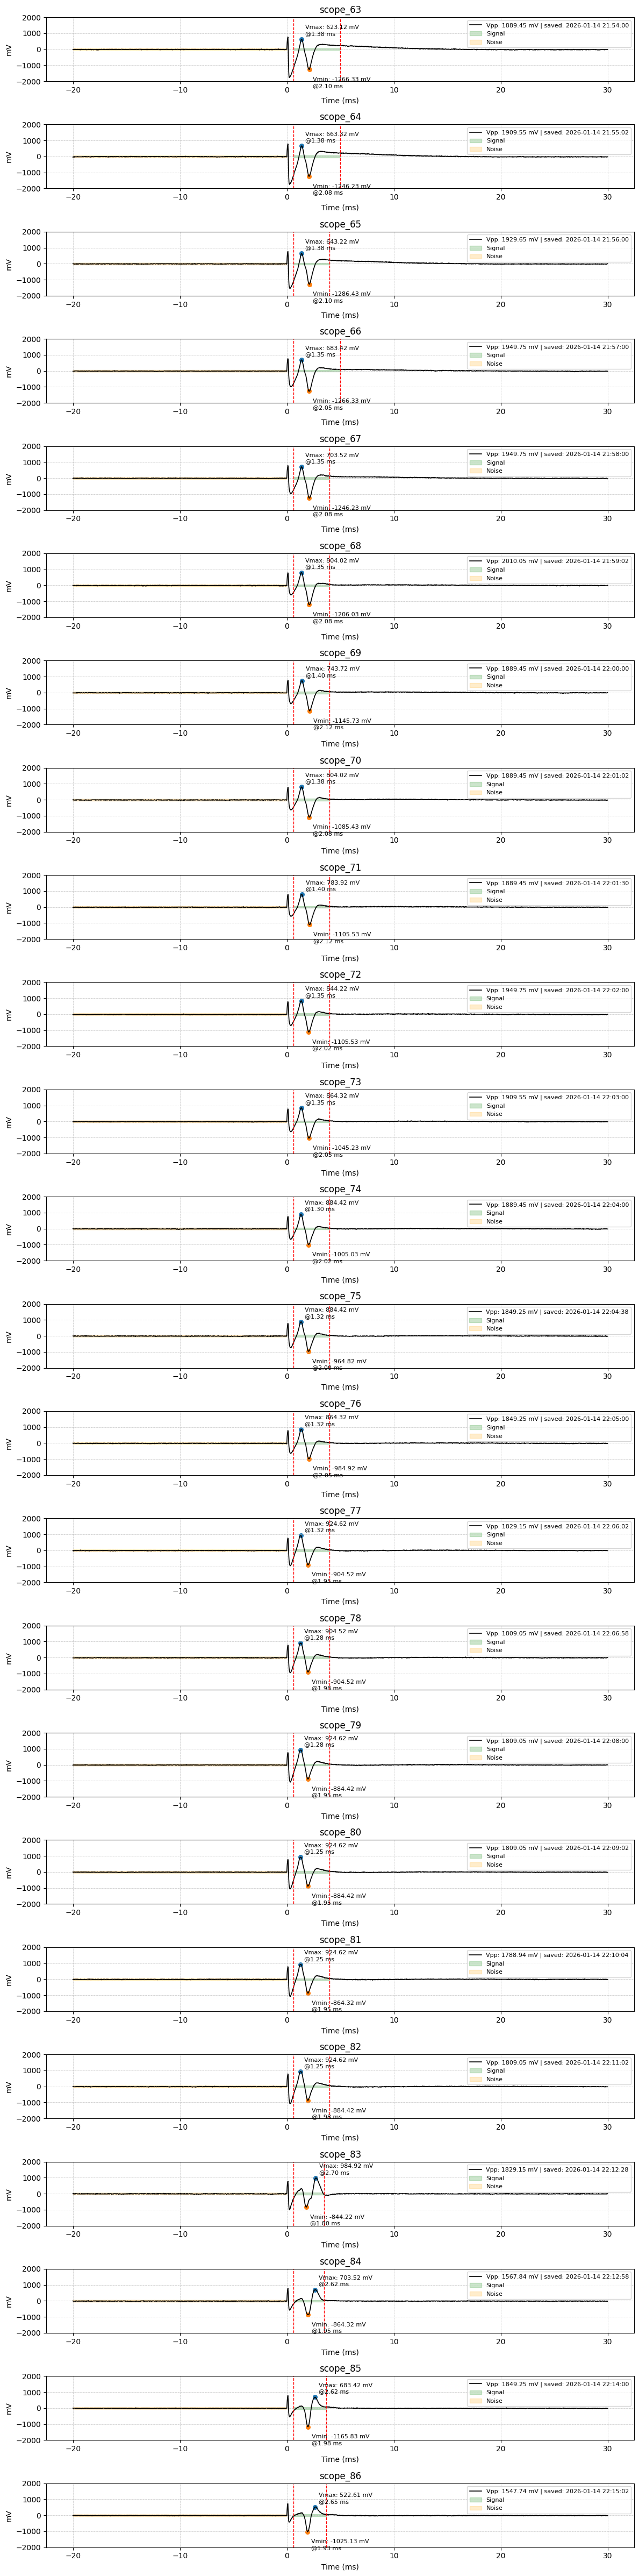

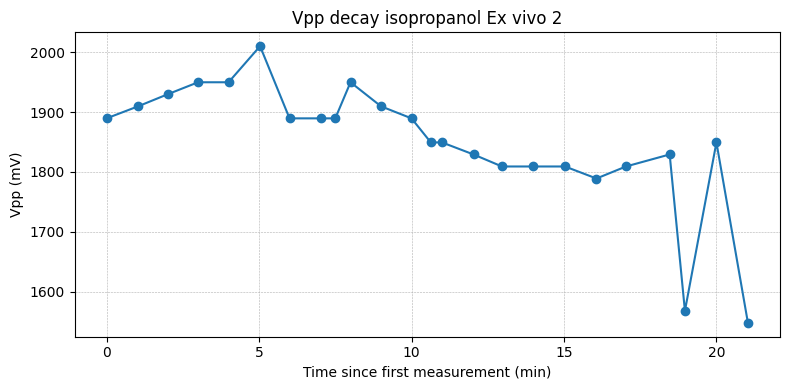

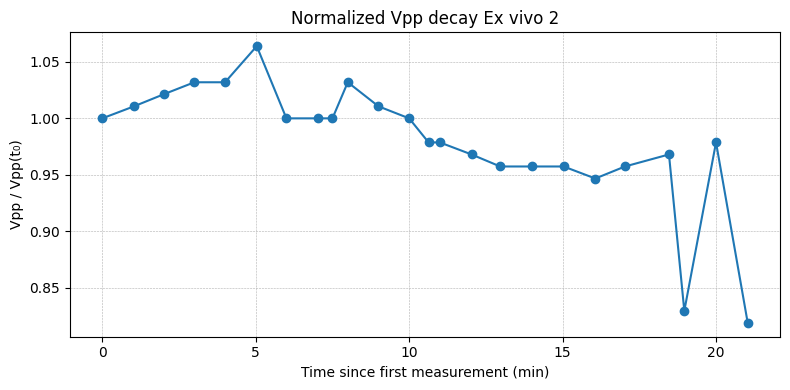


Average SNR (linear): 27.98
Average SNR (dB): 28.94 dB
Average Vpp: 1850.08 mV


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
from zoneinfo import ZoneInfo

folder = "Ex vivo 2"
scope_start = 63
num_files = 24

time_windows = [
    (0.6, 5),   # Scope_63
    (0.6, 5),   # Scope_64
    (0.6, 4),   # Scope_65
    (0.6, 5),   # Scope_66
    (0.6, 4),   # Scope_67
    (0.6, 4),   # Scope_68
    (0.6, 4),   # Scope_69
    (0.6, 4),   # Scope_70
    (0.6, 4),   # Scope_71
    (0.6, 4),   # Scope_72
    (0.6, 4),   # Scope_73
    (0.6, 4),   # Scope_74
    (0.6, 4),   # Scope_75
    (0.6, 4),   # Scope_76
    (0.6, 4),   # Scope_77
    (0.6, 4),   # Scope_78
    (0.6, 4),   # Scope_79
    (0.6, 4),   # Scope_80
    (0.6, 4),   # Scope_81
    (0.6, 4),   # Scope_82
    (0.6, 3.5),   # Scope_83
    (0.6, 3.5),   # Scope_84
    (0.6, 3.7),   # Scope_85
    (0.6, 3.7),   # Scope_86
]

vpp_values = []
timestamps = []
snr_values = []

fig1, axes = plt.subplots(num_files, 1, figsize=(12, num_files * 2), sharex=False)

for i in range(num_files):
    scope = scope_start + i
    ax = axes[i]
    file_path = os.path.join(folder, f"scope_{scope}.csv")
    t_start, t_end = time_windows[i]

    df = pd.read_csv(file_path)
    df = df.drop(index=0).reset_index(drop=True)
    df = df.apply(pd.to_numeric)

    t_ms = df["x-axis"].values * 1e3
    ch2_mV = df["2"].values * 1e3

    mtime = os.path.getmtime(file_path)
    ts = datetime.fromtimestamp(mtime, tz=ZoneInfo("Europe/Amsterdam"))
    timestamps.append(ts)
    timestamp_str = ts.strftime("%Y-%m-%d %H:%M:%S")

    signal_mask = (t_ms >= t_start) & (t_ms <= t_end)
    noise_mask = (t_ms >= -20) & (t_ms <= -0.01)

    signal_vals = ch2_mV[signal_mask]
    vmax = np.max(signal_vals)
    vmin = np.min(signal_vals)
    vpp = vmax - vmin
    vpp_values.append(vpp)

    seg_indices = np.where(signal_mask)[0]
    idx_vmax = seg_indices[np.argmax(ch2_mV[seg_indices])]
    idx_vmin = seg_indices[np.argmin(ch2_mV[seg_indices])]
    vmax_t = t_ms[idx_vmax]
    vmin_t = t_ms[idx_vmin]

    signal_vrms = np.sqrt(np.mean(ch2_mV[signal_mask] ** 2))
    noise_vrms = np.sqrt(np.mean(ch2_mV[noise_mask] ** 2))
    snr = signal_vrms / noise_vrms
    snr_values.append(snr)

    print(f"scope_{scope}  SNR: {snr:.2f}")

    ax.plot(
        t_ms,
        ch2_mV,
        linewidth=1.2,
        color="black",
        label=f"Vpp: {vpp:.2f} mV | saved: {timestamp_str}",
    )

    ax.axvline(t_start, color="red", linestyle="--", linewidth=1)
    ax.axvline(t_end, color="red", linestyle="--", linewidth=1)

    ax.fill_between(t_ms, -60, 60, where=signal_mask, color="green", alpha=0.2, label="Signal")
    ax.fill_between(t_ms, -60, 60, where=noise_mask, color="orange", alpha=0.2, label="Noise")

    ax.scatter(vmax_t, vmax, s=30)
    ax.scatter(vmin_t, vmin, s=30)

    ax.annotate(
        f"Vmax: {vmax:.2f} mV\n@{vmax_t:.2f} ms",
        (vmax_t, vmax),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )
    ax.annotate(
        f"Vmin: {vmin:.2f} mV\n@{vmin_t:.2f} ms",
        (vmin_t, vmin),
        xytext=(5, -24),
        textcoords="offset points",
        fontsize=8,
    )

    ax.set_ylim(-2000, 2000)
    ax.set_ylabel("mV")
    ax.set_xlabel("Time (ms)")
    ax.set_title(f"scope_{scope}")
    ax.grid(True, which="both", linestyle="--", linewidth=0.4)
    ax.legend(loc="upper right", fontsize=8)

fig1.tight_layout()
plt.show()

pairs = sorted(zip(timestamps, vpp_values), key=lambda x: x[0])
t0 = pairs[0][0]

time_min = np.array([(ts - t0).total_seconds() / 60.0 for ts, _ in pairs])
vpp_arr = np.array([vpp for _, vpp in pairs])

plt.figure(figsize=(8, 4))
plt.plot(time_min, vpp_arr, "o-")
plt.xlabel("Time since first measurement (min)")
plt.ylabel("Vpp (mV)")
plt.title(f"Vpp decay isopropanol {folder}")
plt.grid(True, which="both", linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()

vpp_norm = vpp_arr / vpp_arr[0]

plt.figure(figsize=(8, 4))
plt.plot(time_min, vpp_norm, "o-")
plt.xlabel("Time since first measurement (min)")
plt.ylabel("Vpp / Vpp(t₀)")
plt.title(f"Normalized Vpp decay {folder}")
plt.grid(True, which="both", linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()

snr_mean = np.mean(snr_values)
snr_mean_db = 20 * np.log10(snr_mean)
print(f"\nAverage SNR (linear): {snr_mean:.2f}")
print(f"Average SNR (dB): {snr_mean_db:.2f} dB")

vpp_mean = np.mean(vpp_values)
print(f"Average Vpp: {vpp_mean:.2f} mV")